# Gerando polígonos de vias no município de São Paulo

A intenção desse notebook é demonstrar e fomentar técnicas de trabalho de geoprocessamento com linguaem de programação, tentando obter um polígono de vias do município de São Paulo utilizando as seguintes camadas do [Geosampa](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/_SBC.aspx) 

* [Logradouros](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadIfr.aspx?orig=DownloadCamadas&arq=05_Sistema%20Vi%E1rio%5C%5CLogradouro%5C%5CShapefile%5C%5CSIRGAS_SHP_logradouronbl&arqTipo=Shapefile)
* [Quadras Viárias](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadIfr.aspx?orig=DownloadCamadas&arq=11_Cadastro%5C%5CQuadra%5C%5CShapefile%5C%5CSIRGAS_SHP_quadraMDSF&arqTipo=Shapefile)

Para nossos primeiros experimentos vamos recortar ambas as camadas pela folha número 3316-221 do _SCM_ (Sistema Cartográfico Municipal). Esses arquivos processados estão na pasta gis desse projeto. 

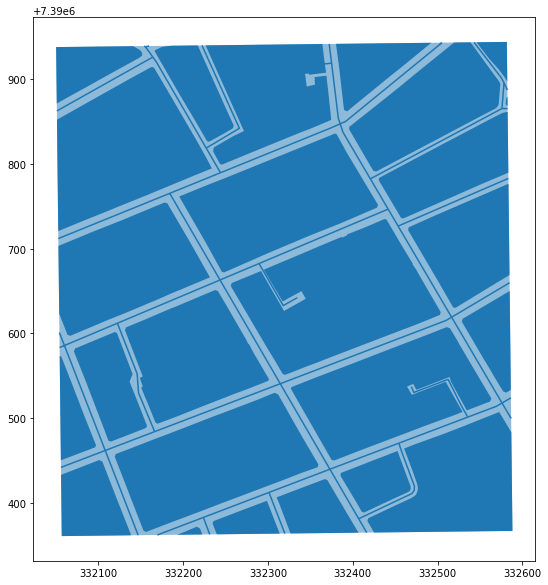

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (20, 10)


df_scm = gpd.read_file('./gis/scm-3316-221.geojson')
df_quadras = gpd.read_file('./gis/quadras-3316-221.geojson')
df_logradouros = gpd.read_file('./gis/logradouros-3316-221.geojson')

f, ax = plt.subplots(1)
df_scm.plot(ax=ax, alpha=0.5)
df_quadras.plot(ax=ax)
df_logradouros.plot(ax=ax)

plt.show()



## Importando shapefiles para o Postgis

Inicialmente optamos por trabalhar com os dados georeferenciados dentro do banco de dados PostGis. Para isso é necessário importar os Shapefiles para dentro do banco. Neste post é possível aprender [3 maneiras de importar ShapeFiles para dentro do banco de dados PostGis](http://www.clickgeo.com.br/formas-de-importar-shapes-postgis/)



## Trabalhando com o banco de dados PostGis

A primeira estratégia a ser testada vai ser de criar uma geometria única com as ruas que será resultante da intersecção do poígono da SCM total com as quadras. Depois de obtido esse polígono então vamos utilizar o [ST_ApproximateMedialAxis](https://postgis.net/docs/ST_ApproximateMedialAxis.html) para traçar uma rede central e a partir dai tentar dividir o polígono total baseado nos nós de interesecção.

In [3]:
from sqlalchemy import create_engine
from env import *

engine = create_engine("postgresql+psycopg2://%s:%s@%s:%s/%s"%(user, password, host, port, database))
print (engine.table_names())

['quadras', 'scm', 'sqls_tita', 'scm_1_5000', 'logradouros', 'vias']


### Criando os dataframes pelo Banco de Dados

In [4]:
df_scm = gpd.GeoDataFrame.from_postgis(sql="SELECT * from public.scm;", con=engine)
df_quadras = gpd.GeoDataFrame.from_postgis(sql="SELECT * from public.quadras;", con=engine)

### Gerando as diferenças entre as feições do SCM com a quadra

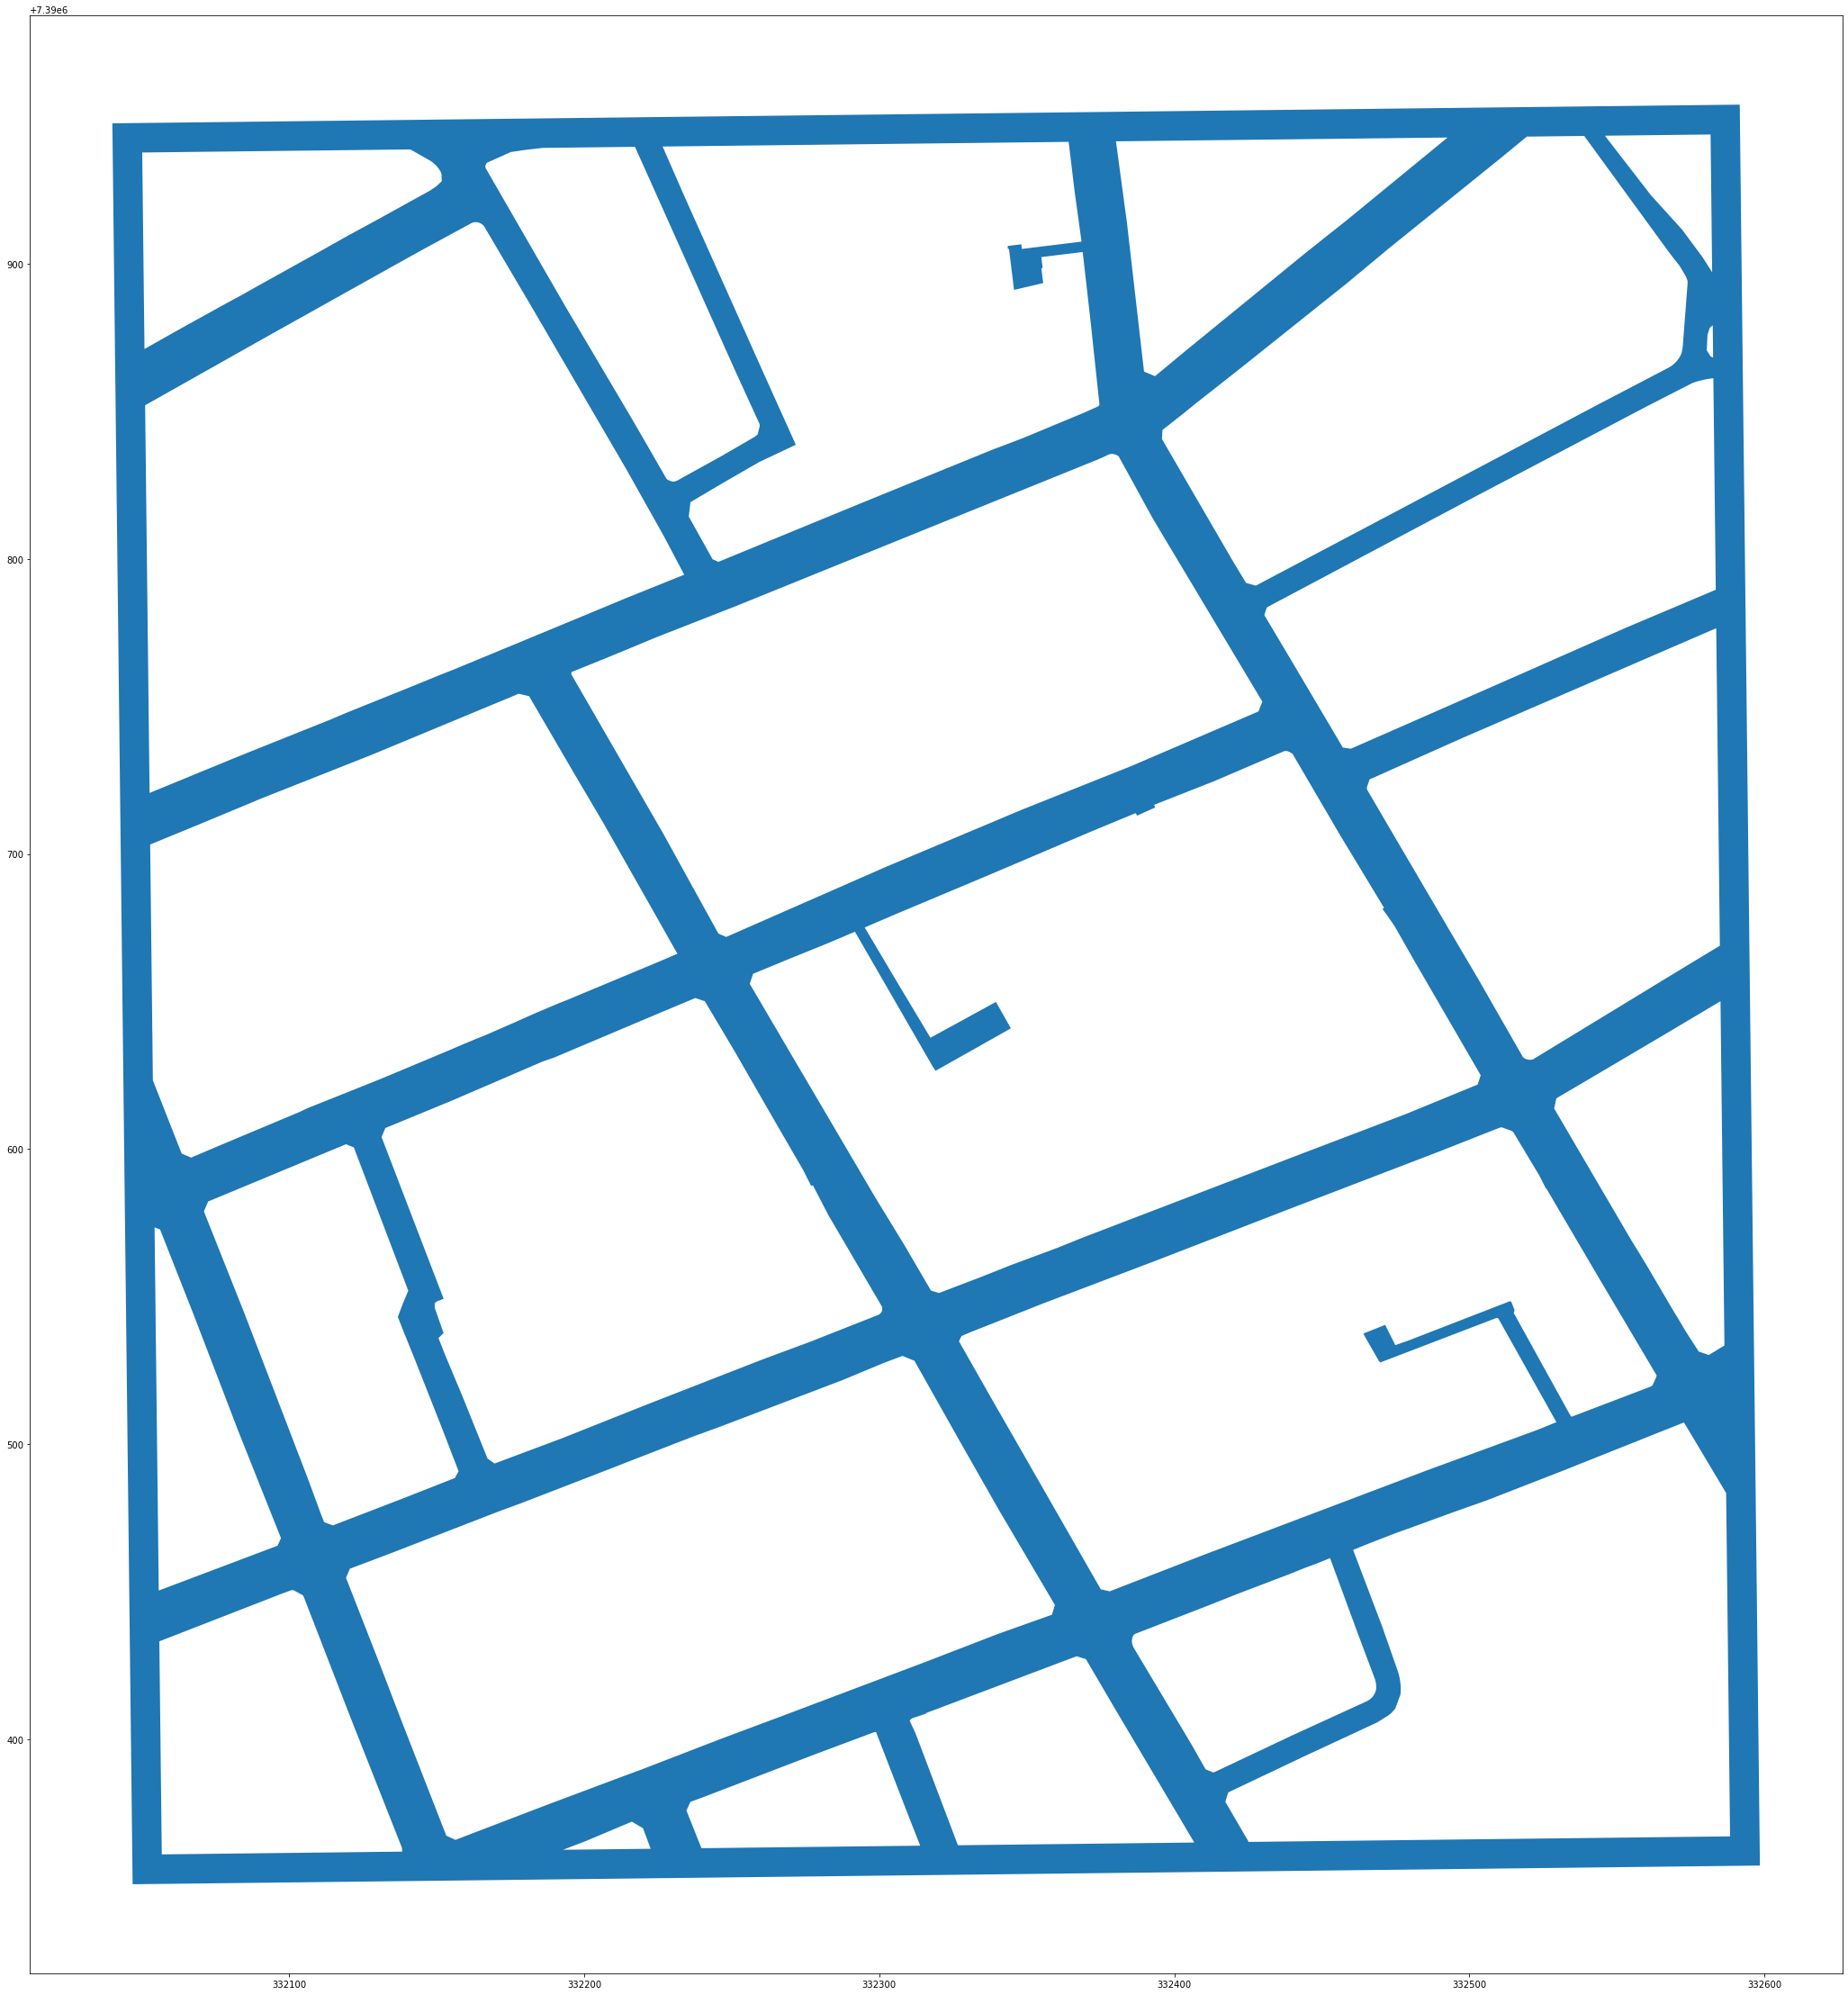

In [5]:
df_vias = gpd.overlay(df_scm, df_quadras, how='difference')
plt.rcParams['figure.figsize'] = (40, 40)
df_vias.plot()

### Persistindo a geometria na base de dados

In [6]:
from geoalchemy2 import Geometry, WKTElement

# df_vias['geom'] = df_vias['geom'].apply(lambda x: WKTElement(x.wkt, srid=31983))
# df_vias.to_sql('vias', con=engine, schema='public', if_exists='replace', index=False, dtype={'geom': Geometry('POLYGON', srid=31983)})

# Instanciando vias novamente 
# df_vias = gpd.GeoDataFrame.from_postgis(sql="select * from vias;", con=engine)

In [7]:
# Esse comando não se monstrou eficiante, além de muito lento
#df_medial_axis = gpd.GeoDataFrame.from_postgis(sql="SELECT ST_ApproximateMedialAxis(ST_MakeValid(geom)) as geom from public.vias;", con=engine)

## Definindo uma nova estratégia

Como o MedialAxis não funcionou com uma quantidade essa quantidade de rings no polígono provavelmente vamos ter que descarta-lo e utilizar as próprias linhas do traçado do viário para recortar esse polígono

### capturando os pontos iniciais de conexão de logradouros

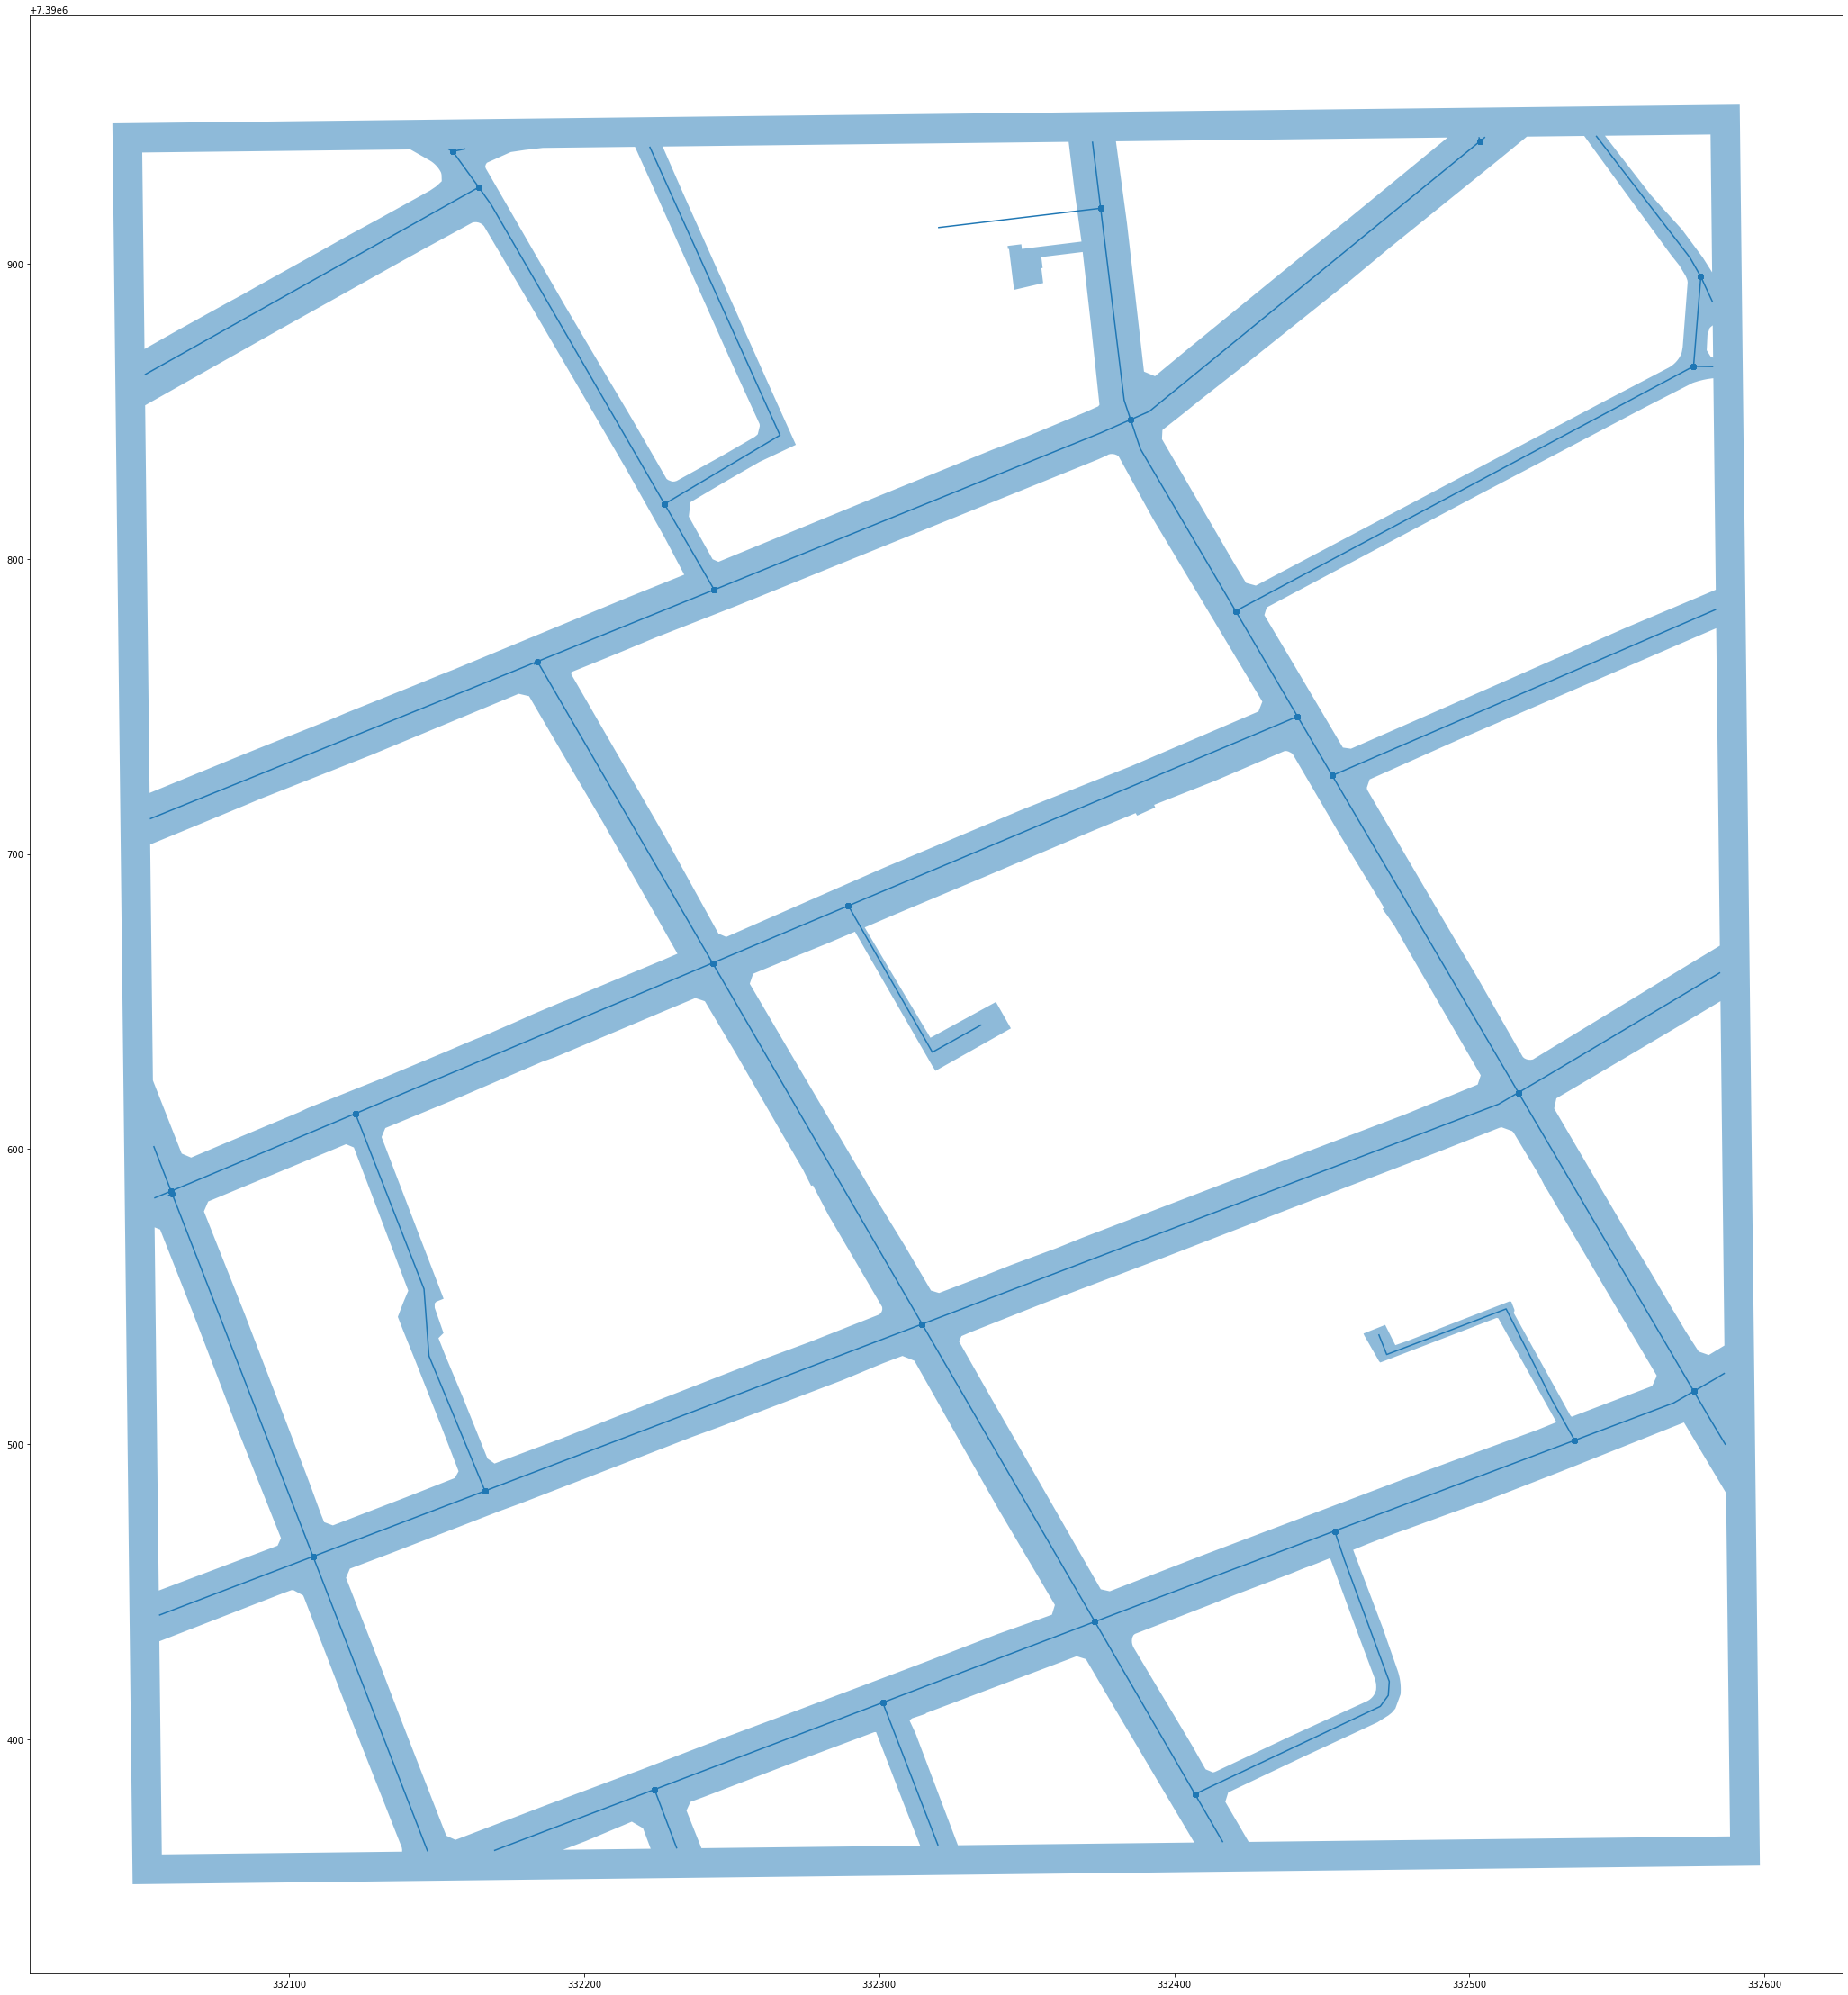

In [8]:
sql_cruzamentos = """ 

select st_intersection(a.geom, b.geom) as geom 
from logradouros as a, logradouros as b 
where st_touches(a.geom, b.geom); """

df_cruzamentos = gpd.GeoDataFrame.from_postgis(sql=sql_cruzamentos, con=engine)

f, ax = plt.subplots(1)
df_vias.plot(ax=ax, alpha=0.5)
df_cruzamentos.plot(ax=ax)
df_logradouros.plot(ax=ax)

plt.show()

Como alguns pontos acabam ficando muito próximos, seria interessante agregar todos os pontos do cruzamento.

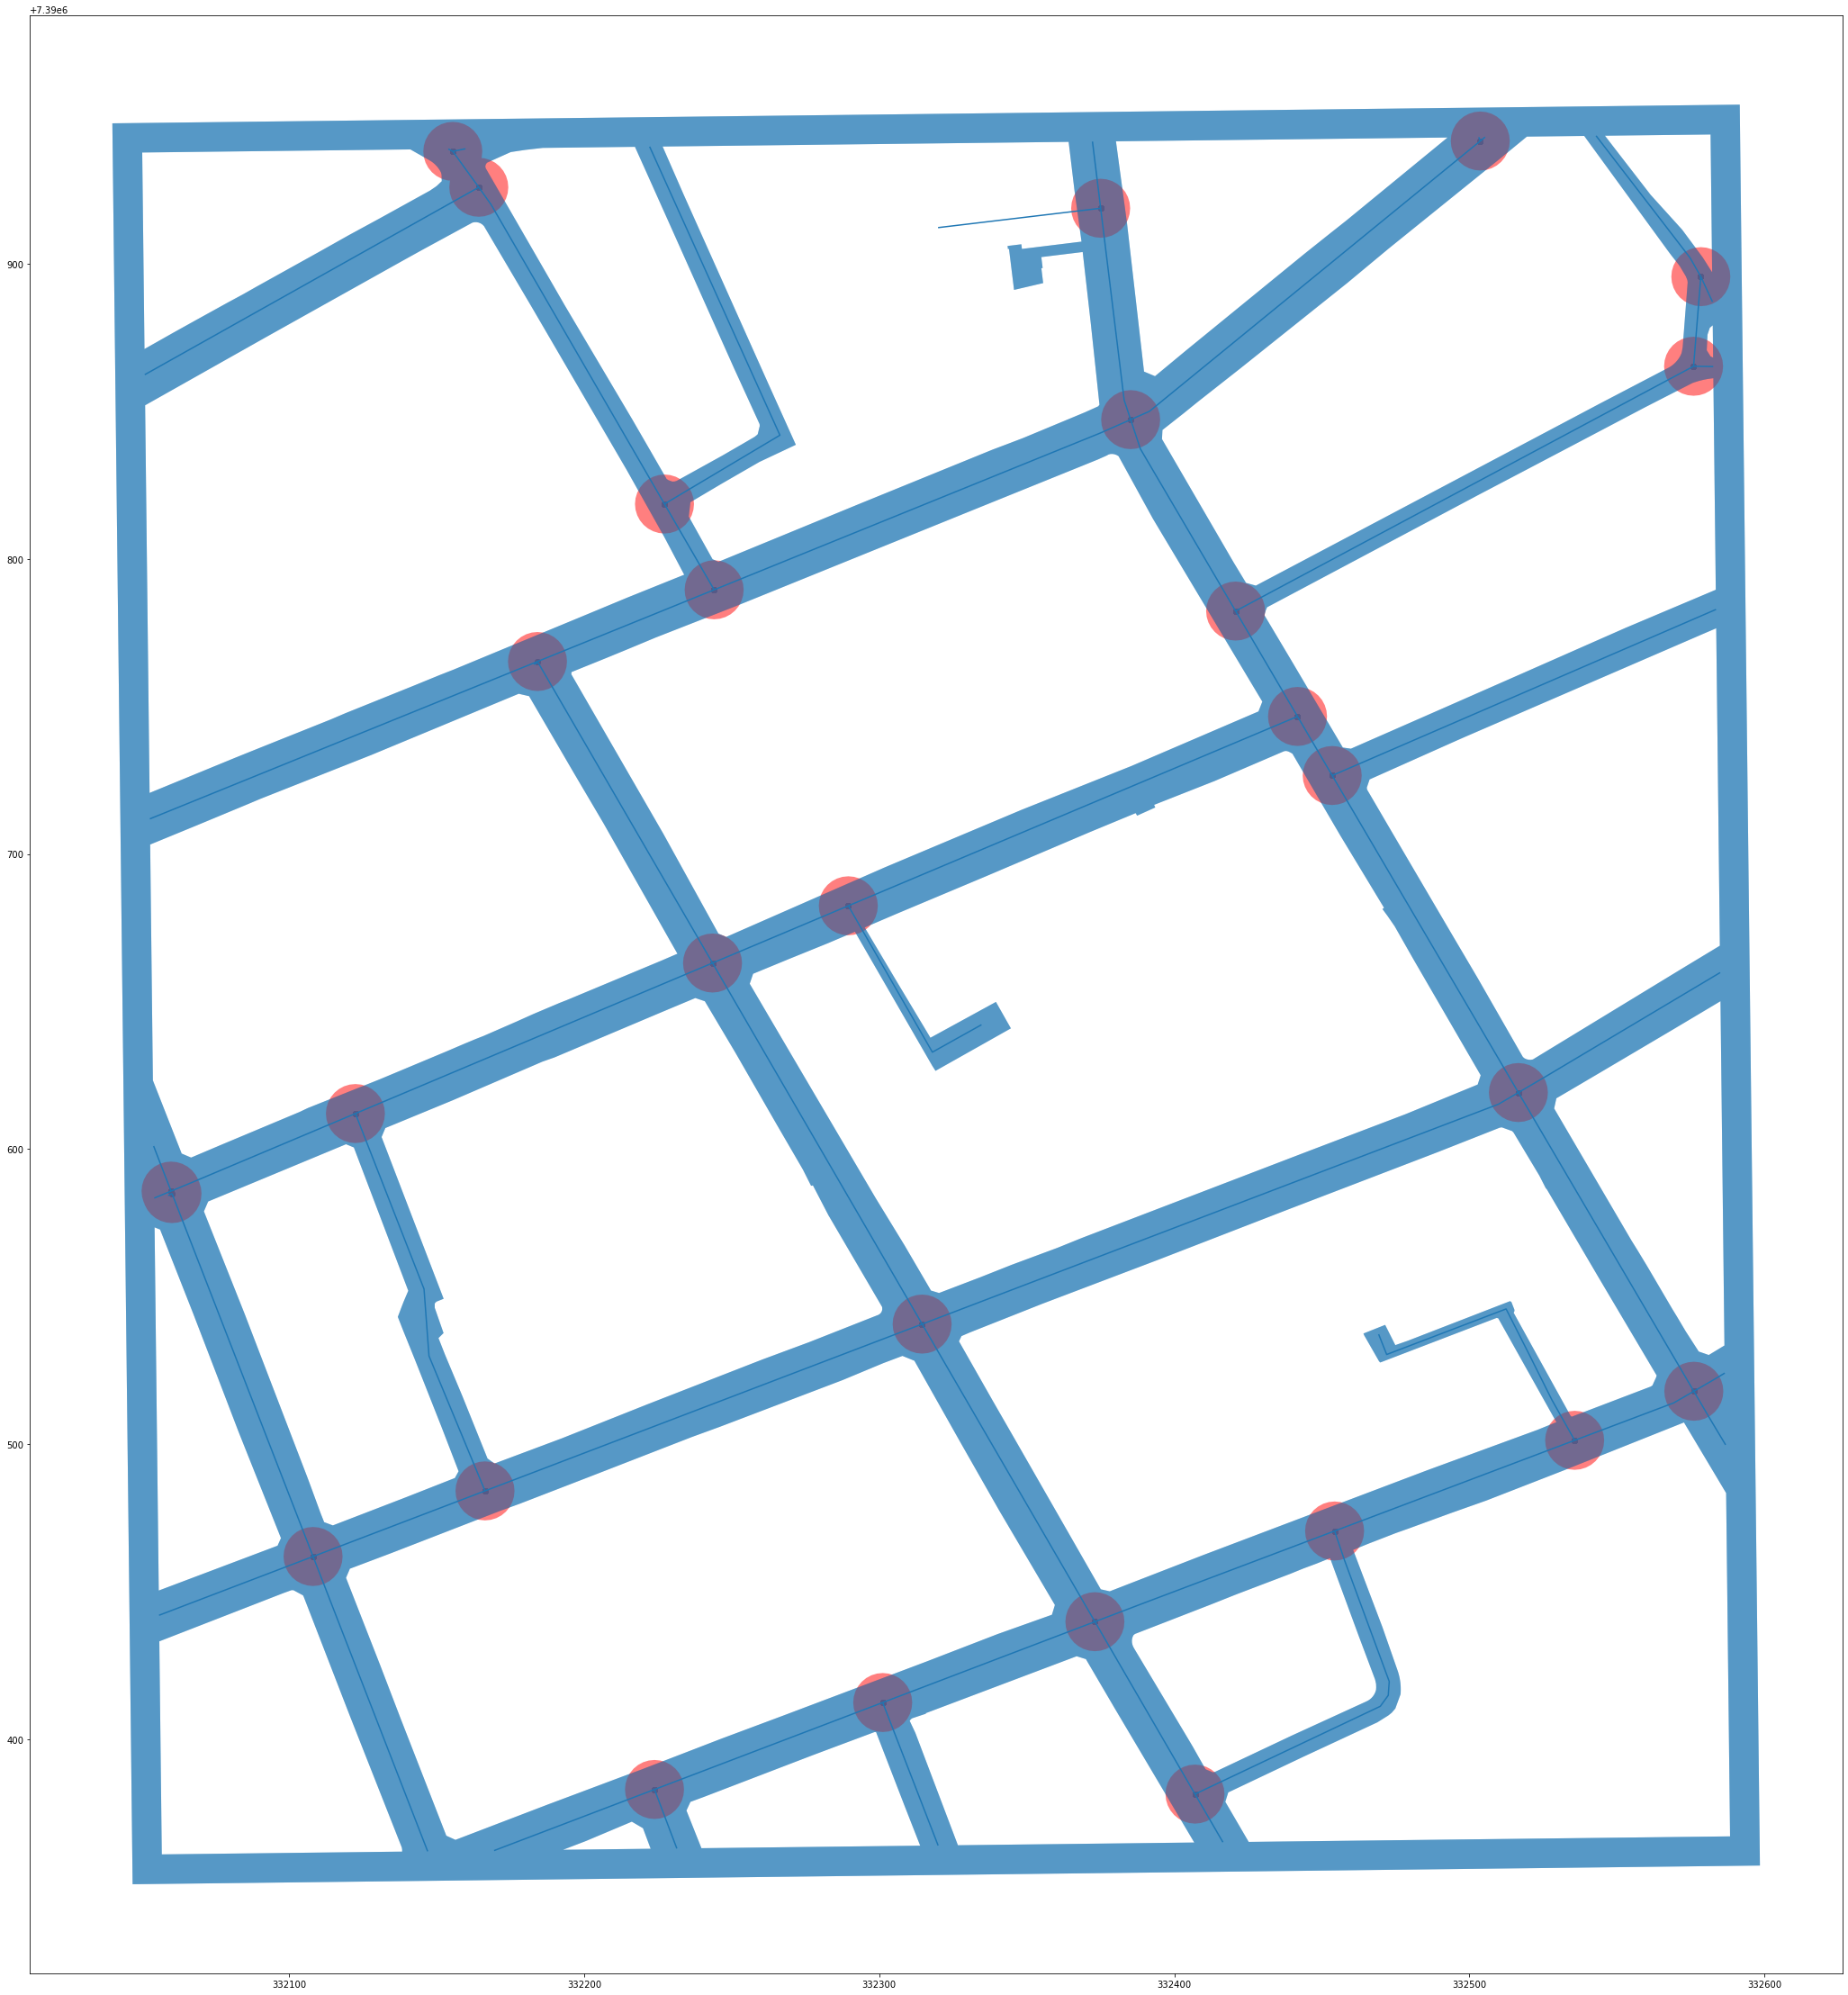

In [9]:
sql_cruz_buffer =  """

select (st_dump(geom)).geom as geom from 
(select st_union(st_buffer(st_intersection(a.geom, b.geom), 10)) as geom 
from logradouros as a, logradouros as b 
where st_touches(a.geom, b.geom)) as sub_query """

df_cruz_buffer = gpd.GeoDataFrame.from_postgis(sql=sql_cruz_buffer, con=engine)

f, ax = plt.subplots(1)
df_vias.plot(ax=ax, alpha=0.5)
df_cruzamentos.plot(ax=ax)
df_logradouros.plot(ax=ax)
df_cruz_buffer.plot(ax=ax, alpha=0.5, color='red')
df_vias.plot(ax=ax, alpha=0.5)

plt.show()

## Criando linhas para 'cortar' os polígonos

Agora que temos que cortar o polígono precisamos de linhas para realizar esse fatiamento. 
Primeiramente vamos criar uma intersecção dos buffers dos nós com o traçado dos logradouros

In [10]:
from shapely.geometry import Polygon, Point, MultiPoint, LineString

Porém antes vamos testar nossa estratégia em uma feição hipotética para fixar o conhecimento ...

In [208]:
%%time

from shapely.ops import split
from math import atan2, degrees
from shapely.affinity import rotate, scale

# criando um polígono de cruzamento hipotético
poligono =  Point((0,0)).buffer(1)
df_poligono = gpd.GeoDataFrame([0], geometry=[poligono])

# criando linhas de traçado viário hipotéticas
linha1 = LineString([Point(0, 0), Point(2, 2)])
linha2 = LineString([Point(0, 0), Point(-1, 2)])
linha3 = LineString([Point(-0.1, -0.1), Point(1, -2)])
df_linha = gpd.GeoDataFrame([0, 1, 2], geometry=[linha1, linha2, linha3])

inter_poligono_linha = df_linha.unary_union.intersection(df_poligono.unary_union)
df_inter_poligono_linha = gpd.GeoDataFrame([0], geometry=[inter_poligono_linha])

inter_ponto_borda = df_poligono.boundary.intersection(df_linha.unary_union)
df_inter_ponto_borda = gpd.GeoDataFrame([0], geometry=inter_ponto_borda)
cx, cy = df_poligono.geometry.centroid.x, df_poligono.geometry.centroid.y
angulos = [degrees(atan2(point.y - cy, point.x - cx)) for point in inter_ponto_borda[0]]
print(angulos)


nova_linha = [LineString([Point(0,0), point]) for point in inter_ponto_borda[0]]
df_nova_linha = gpd.GeoDataFrame(list(range(len(nova_linha))), geometry=nova_linha)
df_nova_linha.columns = ['index', 'geometry']
df_nova_linha['geometry'] = df_nova_linha['geometry'].scale(xfact=1.5, yfact=1.5, origin=(0,0))


#rotacionar o poligono para que o ponto inicial coincida com algum segmento
#TODO
poligono = rotate(poligono, angulos[0], origin=(cx, cy))

fatiado = split(poligono.boundary, df_nova_linha.unary_union)
fatias = [fatia for fatia in fatiado]
df_fatiado = gpd.GeoDataFrame(list(range(len(fatias))), geometry=fatias)
df_fatiado.columns = ['index', 'geometry']
print(df_fatiado)


ponto_medio = [fatia.interpolate(0.5, normalized=True) for fatia in fatiado]
df_ponto_medio = gpd.GeoDataFrame(list(range(len(ponto_medio))), geometry=ponto_medio)
df_ponto_medio.columns = ['index', 'geometry']


[116.56505117707799, -67.78708909885995, 45.0]
   index                                           geometry
0      0    LINESTRING (-0.44721 0.89443, -0.44721 0.89443)
1      1  LINESTRING (-0.44721 0.89443, -0.35739 0.93395...
2      2  LINESTRING (0.70642 0.70642, 0.72609 0.68760, ...
3      3  LINESTRING (0.37773 -0.92500, 0.35739 -0.93395...
Wall time: 15.6 ms


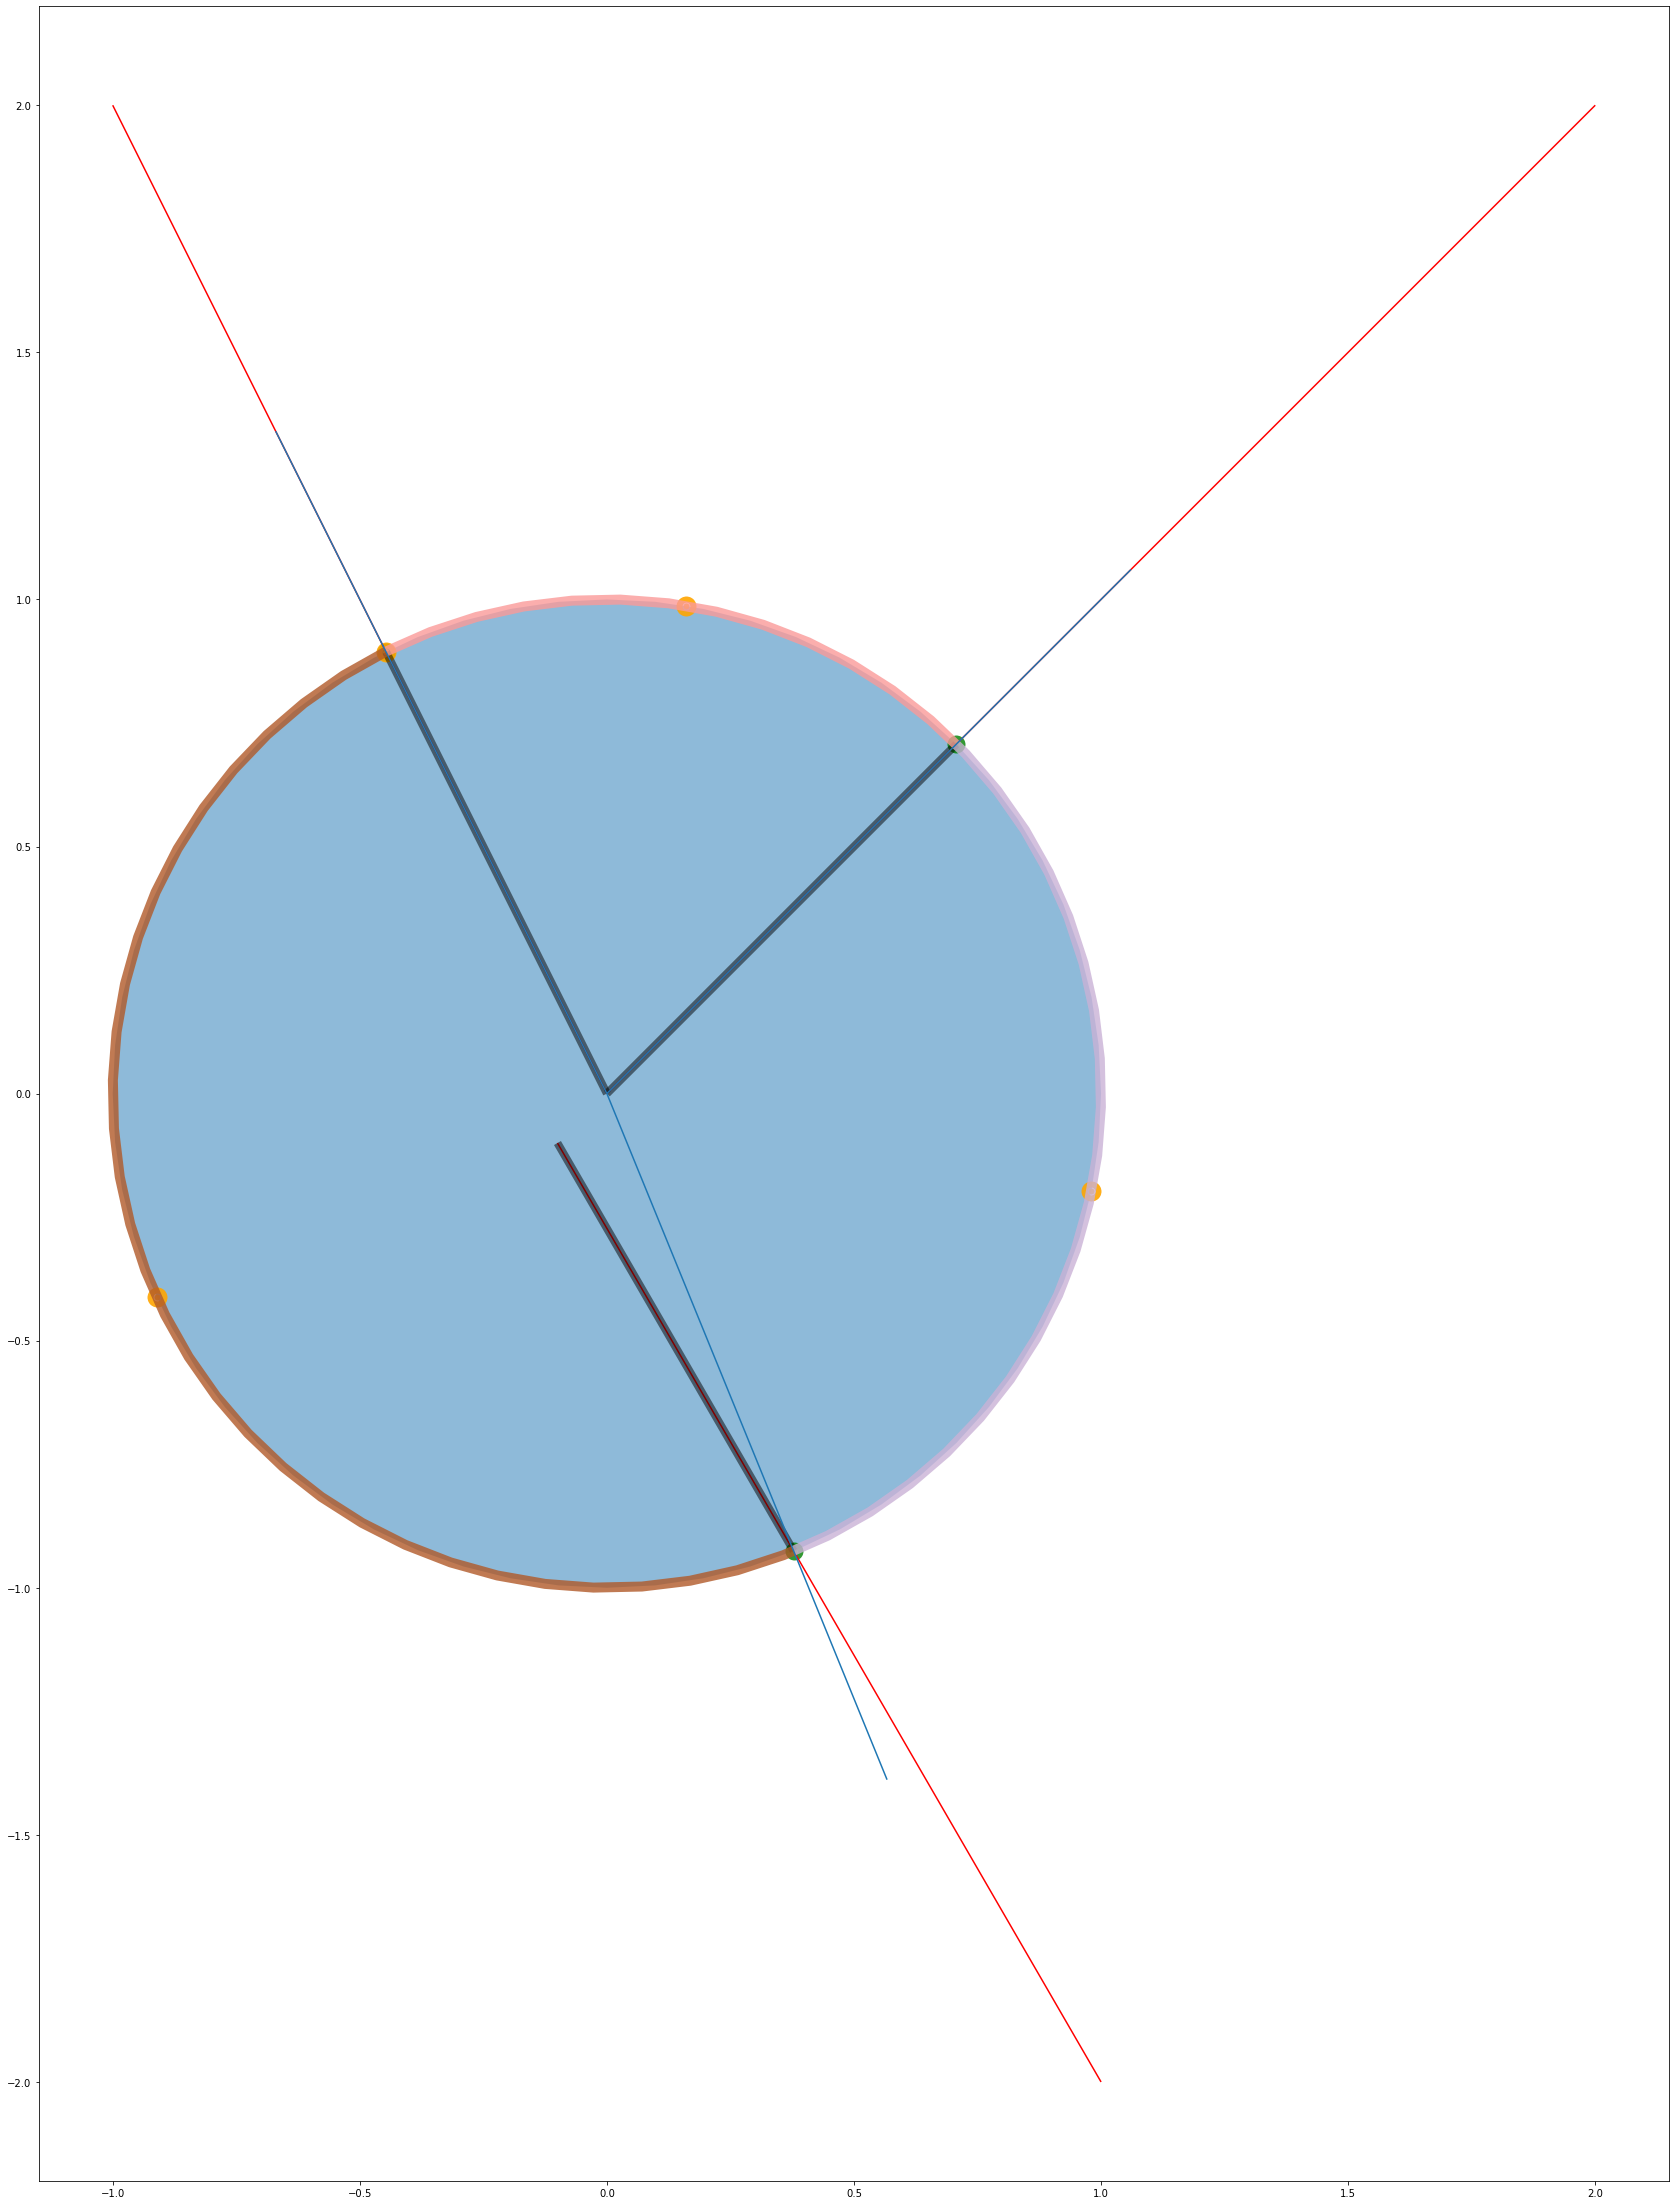

In [112]:
f, ax = plt.subplots(1)

df_poligono.plot(ax=ax, alpha=0.5)
df_linha.plot(ax=ax, color='red')
df_inter_poligono_linha.plot(ax=ax, color='black', alpha=0.5, linewidth=8)
df_inter_ponto_borda.plot(ax=ax, color='green', alpha=0.8, linewidth=12)
df_fatiado.plot(ax=ax, column='index', lw=3, cmap='Paired', alpha=0.8, linewidth=10)
df_nova_linha.plot(ax=ax)
df_ponto_medio.plot(ax=ax, color='orange', alpha=0.9, linewidth=14)

plt.show()

## Agora voltando a trabalhar nas feições

Agora que conseguimos realizar a estratégia de traçar um buffer ao redor do cruzamento e então gerar linhas nas bissetrizes do traçado do viário podemos repetir o mesmo nas nossas feições.
Relembrando o que temos até aqui:

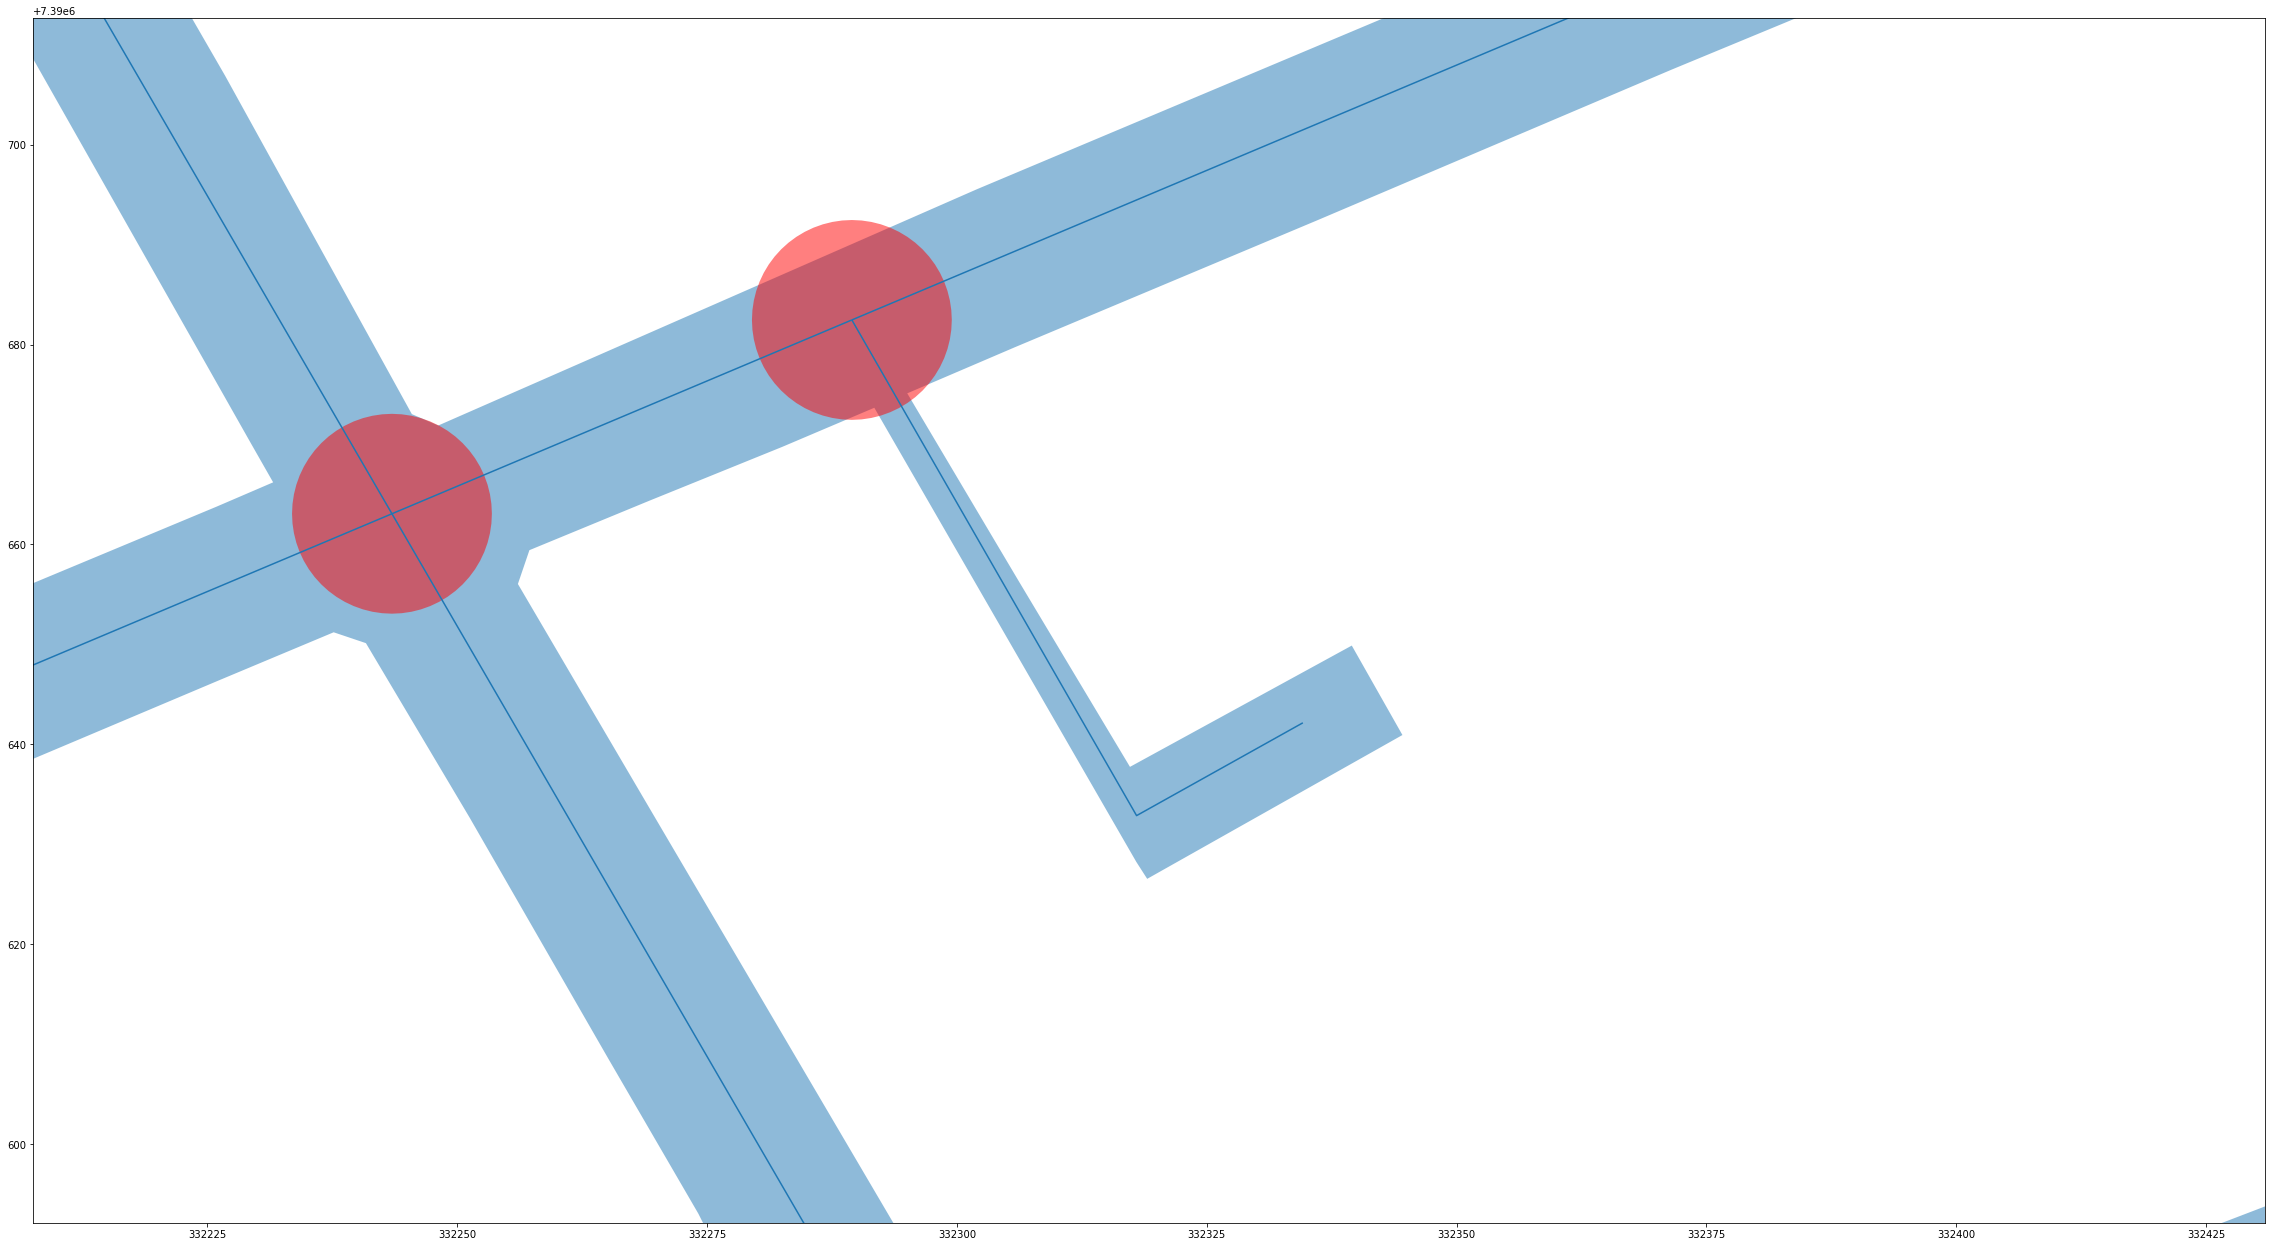

In [138]:
df_vias # nosso polígono de vias, totalmente unido
df_nos = gpd.GeoDataFrame(list(range(len(df_cruz_buffer))), geometry=df_cruz_buffer.centroid.buffer(10)) # os nós que vão nos balizar para fatiar o polígono de vias
df_nos.columns = ['index', 'geometry']
df_logradouros # o tracado dos logradouros

f, ax = plt.subplots(1)

# Aplicando o zoom
plt.margins(x=-0.30, y=-0.40)

df_vias.plot(ax=ax, alpha=0.5)
#df_cruzamentos.plot(ax=ax)
df_logradouros.plot(ax=ax)
df_nos.plot(ax=ax, alpha=0.5, color='red')

plt.show()

Vamos relacionar os logradouros que intersectcam cada um dos nós

In [242]:
%%time

# importando a biblioteca pandas para poder concatenar
import pandas as pd

# relacionando as tabelas
df_logradouros_nos = gpd.sjoin(df_logradouros, df_nos, how='left', op='intersects')

# dissolvendo as feições podemos ter uma feição de multiString por nó o que vai facilitar nos processamentos
# isolando apenas a coluna de geometria e modificando o nome dela já pensando em concatena-la
df_nos_logradouros = df_logradouros_nos.dissolve(by='index').iloc[:, 0:1].rename(columns={'geometry':'geom'})

# concatenando nós e logradouros :-)
df_nos_concatenado = pd.concat([df_nos, df_nos_logradouros], axis=1, sort=False)

# gerando a intersecção de pontos nas bordas dos polígonos de nós
inter_ponto_borda = [f.geometry.boundary.intersection(f['geom']) for i, f in df_nos_concatenado.iterrows()]
df_inter_ponto_borda = gpd.GeoDataFrame(list(range(len(inter_ponto_borda))), geometry=inter_ponto_borda)

# como temos casos onde apenas um traçado de via intersecta com o nó temos que tratar os casos onde existe Point ao inves de MultiPoint
df_inter_ponto_borda['ponto'] = df_inter_ponto_borda['geometry'].apply(lambda x: x if type(x) == type(Point(0,0)) else x[0])

# agora temos que gerar linhas a partir do centro do nó para ponto que intersecta a borda
novas_linhas = []
fator_de_escala = 2 ################### Colocar como parametro do processamento
for i, f in df_nos_concatenado.iterrows():
    c = f.geometry.centroid
    #print(c.coords[0])
    g = df_inter_ponto_borda.iloc[i].geometry
    if type(g) == type(Point(0,0)):
        novas_linhas.append([scale(LineString([c, g]), xfact=fator_de_escala, yfact=fator_de_escala, origin=c.coords[0])])
    else:
        novas_linhas.append([scale(LineString([c, ponto]), xfact=fator_de_escala, yfact=fator_de_escala, origin=c.coords[0]) for ponto in g])
df_nos_concatenado['novas_linhas'] = novas_linhas

# calculando o angulo para girar a feição do nó e fazer coincidir o ponto final com algum ponto de fragmanetação
angulos = [degrees(atan2(df_inter_ponto_borda.iloc[i].ponto.y - f.geometry.centroid.y, df_inter_ponto_borda.iloc[i].ponto.x - f.geometry.centroid.x)) for i, f in df_nos_concatenado.iterrows()]

#rotacionar o poligono para que o ponto inicial coincida com algum segmento
df_nos_concatenado['geometry'] = [rotate(poligono['geometry'], angulos[i], origin=poligono['geometry'].centroid.coords[0]) for i, poligono in df_nos_concatenado.iterrows()]

from shapely.ops import cascaded_union

#fatiado = [split(r.geometry.boundary, cascaded_union(r['novas_linhas'])) for i, r in df_nos_concatenado.iterrows()]
fatiado = [split(r.geometry.boundary, cascaded_union(r['novas_linhas'])) for i, r in df_nos_concatenado.iterrows()]
fatias = [cascaded_union(fatia) for fatia in fatiado]
df_fatiado = gpd.GeoDataFrame(list(range(len(fatias))), geometry=fatias)
df_fatiado.columns = ['index', 'geometry']

################### TODO
################### https://www.mikulskibartosz.name/how-to-split-a-list-inside-a-dataframe-cell-into-rows-in-pandas/
df_fatiado.geometry.apply(pd.Series).merge(df_fatiado, right_index = True, left_index = True).drop(["geometry"], axis = 1).melt(id_vars = ['index'], value_name = "ingredient")


#ponto_medio = [r.geometry.interpolate(0.5, normalized=True) for i, r in df_fatiado.iterrows()]
#ponto_medio
#df_ponto_medio = gpd.GeoDataFrame(list(range(len(ponto_medio))), geometry=ponto_medio)
#df_ponto_medio.columns = ['index', 'geometry']
#df_ponto_medio.plot()


Wall time: 156 ms


,index,variable,ingredient
0,0,0,LINESTRING (332416.0221850581 7390385.69799056...
1,1,0,LINESTRING (332227.3355810905 7390373.63851878...
2,2,0,LINESTRING (332304.7581495534 7390403.13197896...
3,3,0,LINESTRING (332111.6907183286 7390452.62543715...
4,4,0,LINESTRING (332378.0812694523 7390431.21084316...
...,...,...,...
130,22,4,NaN
131,23,4,NaN
132,24,4,NaN
133,25,4,NaN


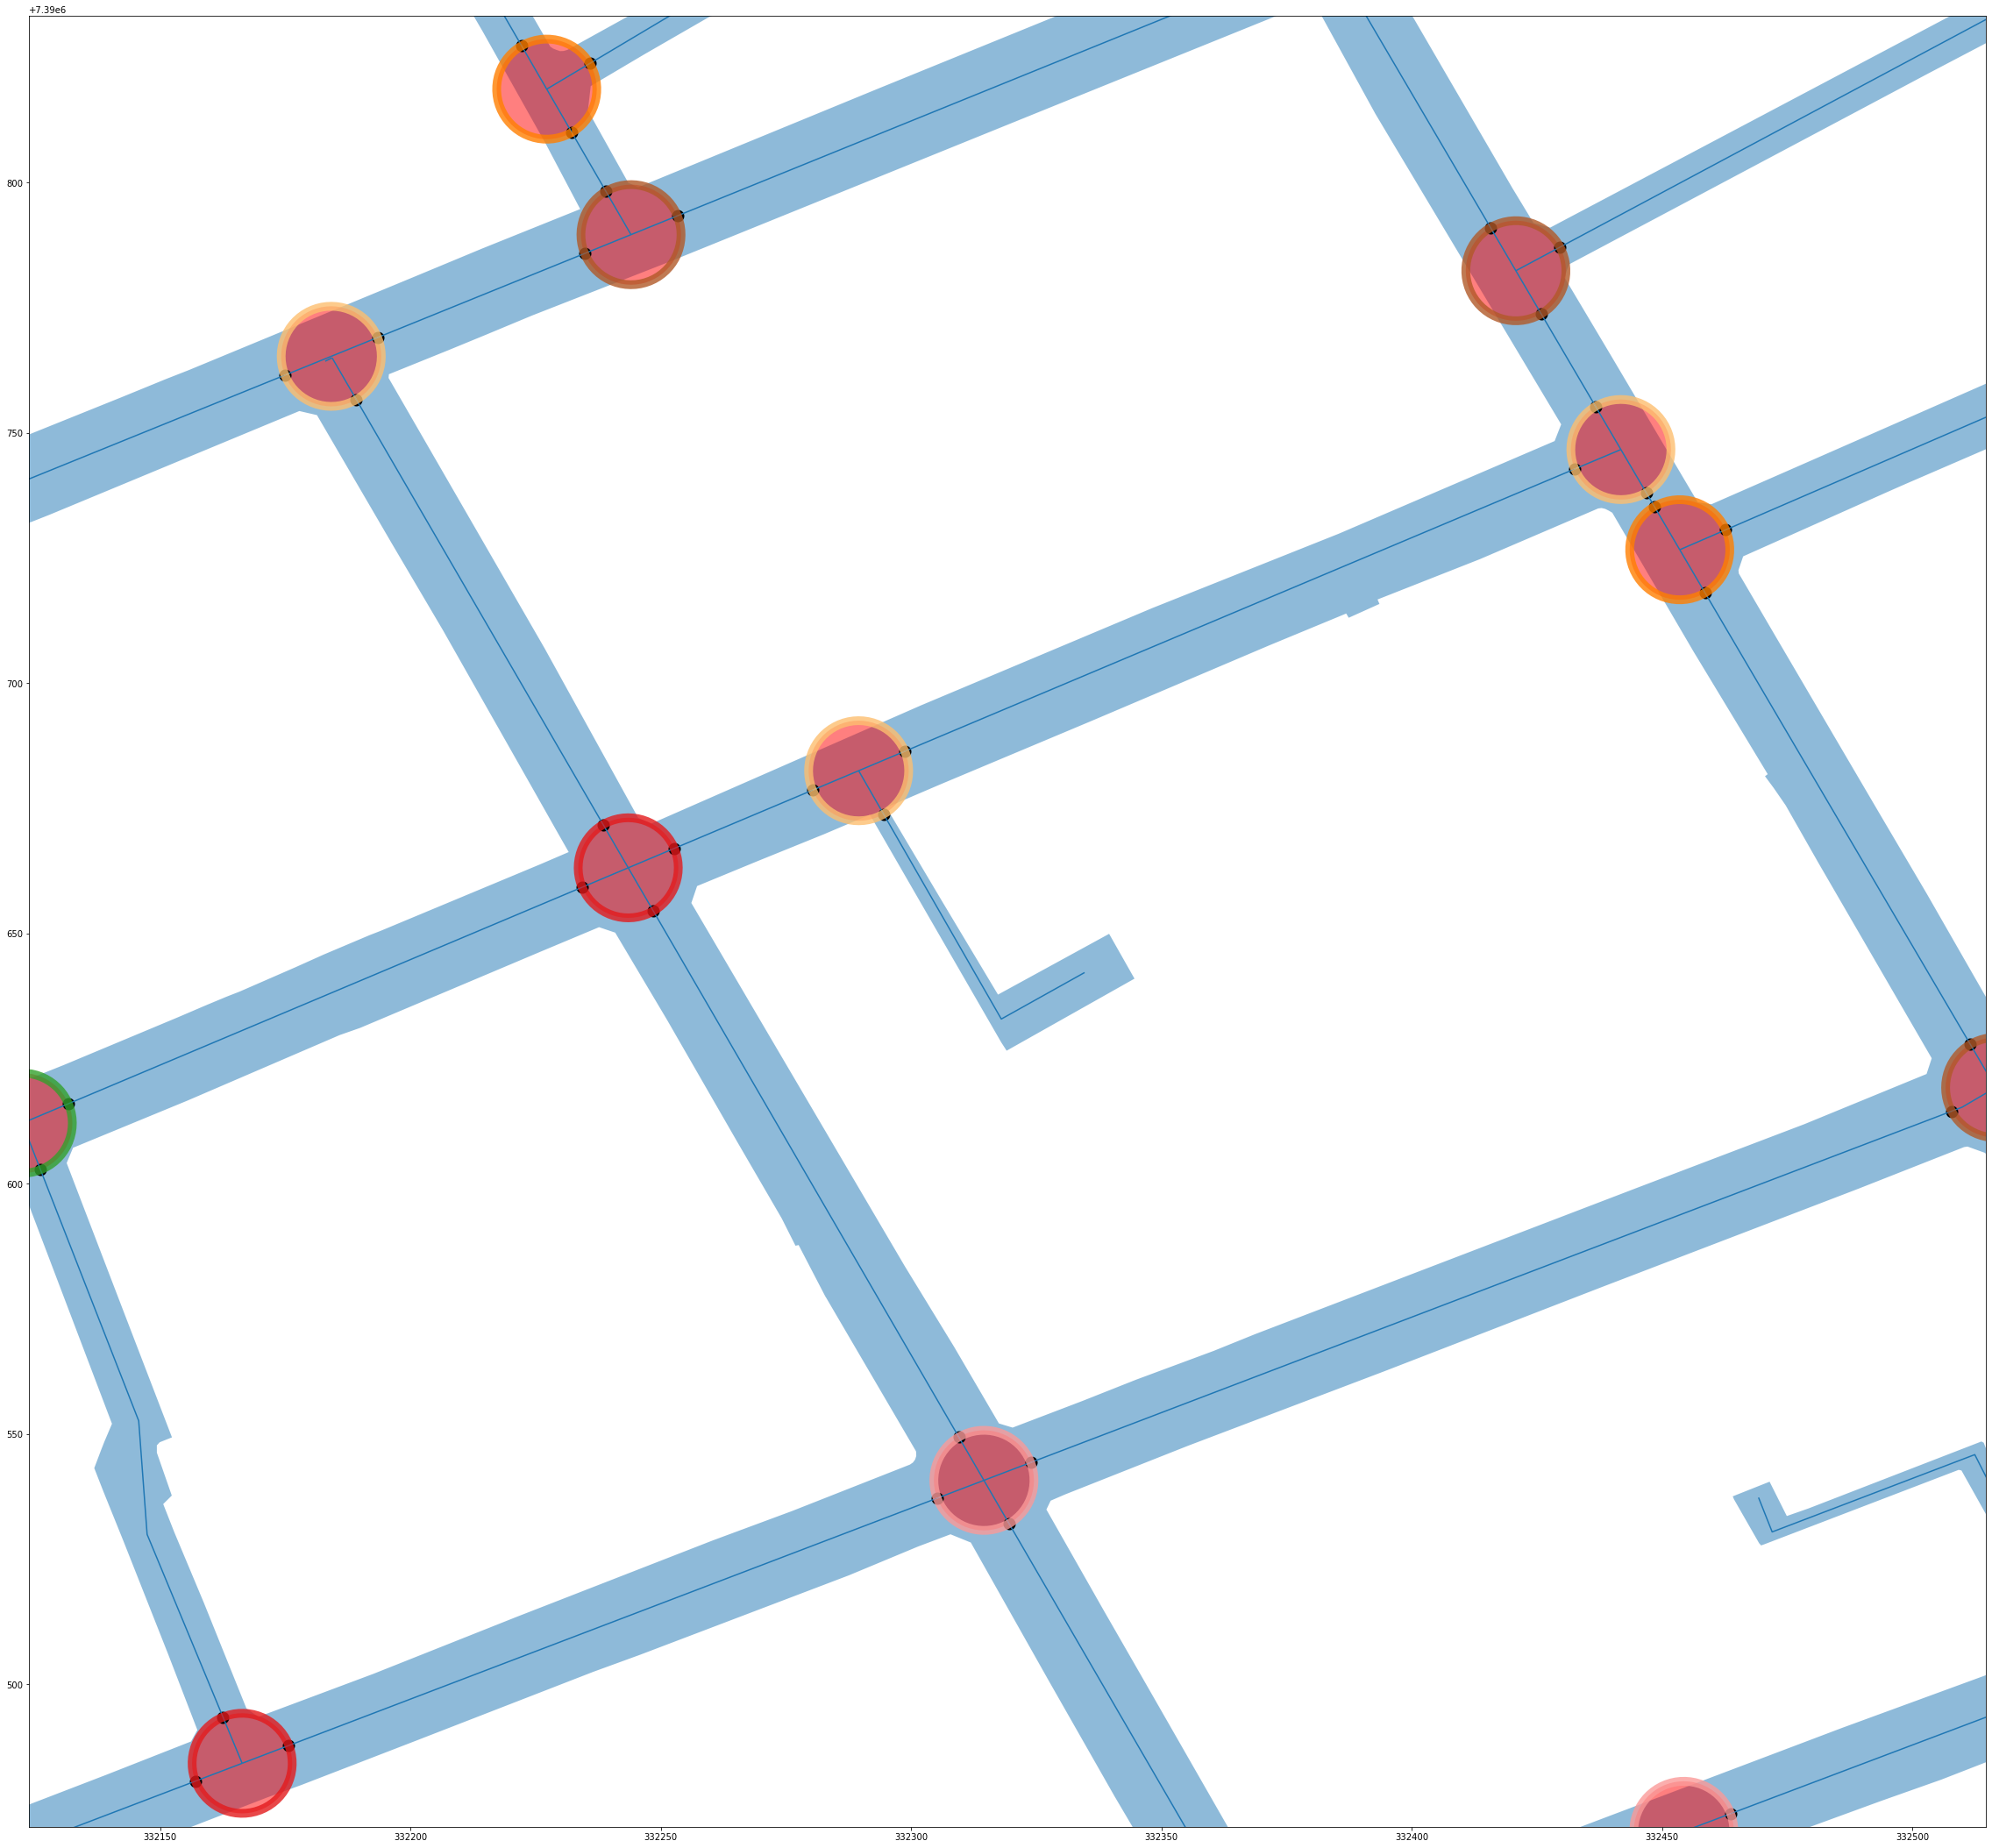

In [210]:
f, ax = plt.subplots(1)

# Aplicando o zoom
plt.margins(x=-0.15, y=-0.20)

df_vias.plot(ax=ax, alpha=0.5)
#df_cruzamentos.plot(ax=ax)
df_logradouros.plot(ax=ax)
df_nos.plot(ax=ax, alpha=0.5, color='red')
df_inter_ponto_borda.plot(ax=ax, color='black', linewidth=8)
#df_fatiado.plot(ax=ax, column='index', lw=3, cmap='Paired', alpha=0.8, linewidth=2)
df_fatiado3.plot(ax=ax, column='index', lw=3, cmap='Paired', alpha=0.8, linewidth=10)
plt.show()